In [6]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import shutil
import glob
from scipy import ndimage
from scipy import signal
#import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings
import csv
import tensorflow as tf
# Pandas is used for data manipulation
import pandas as pd

In [7]:
# Constants
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.91
CUBE_SIZE = 250
EDGE_GAP = 50
ROOT_FOLDER = "/media/1KGB_ILAN/papyrus/files/"
# ROOT_FOLDER = "/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/files/"
LEARNING_RATE = 0.001
BATCHES = 800
BATCH_SIZE = 50
BREAK_VAL = 1000

cube_size = 250
HORIZ_TOLERANCE_FACTOR = 50
VERT_TOLERANCE_FACTOR = 75
EDGE_GAP = 50

In [11]:
# UTILS
def renameFragmentsFiles(path):
    for root, dirs, files in os.walk(path):
        for file_ in files:
            split = file_.split("_")
            if len(split) > 1 and split[0] != '.DS':
                fileSplit = split[0].split("-")

                # next line for testing !!!
                newFileName = fileSplit[0] + fileSplit[1] + "_" + split[1] + "_" + split[2]

                # next line for validation !!!
                #newFileName = fileSplit[0] + fileSplit[1] + ".jpg"

                os.rename(os.path.join(root, file_), 
                          os.path.join(root, newFileName))
    

def handle_match_row(df, idx, df_row):
    rectanglesArr = eval(df_row["fragmentAndSideDrawRect"])
    if len(rectanglesArr) > 0:
        firstImg = Image.open(ROOT_FOLDER+"fragments/"+df_row["firstFileName"]+".jpg")
        secondImg = Image.open(ROOT_FOLDER+"fragments/"+df_row["secondFileName"]+".jpg")
        # import pdb; pdb.set_trace()
        firstRotate = (df_row["fragmentAndSide"][df_row["fragmentAndSide"].rfind("P")-2] == "0")
        secondRotate = (df_row["fragmentAndSide"][-1] == "1")

        # rotate the images if needed
        if firstRotate:
            firstImg = firstImg.rotate(180)
        if secondRotate:
            secondImg = secondImg.rotate(180)

        cubesArr = eval(df_row["fragmentAndSideCubes"])
        pointsArr = eval(df_row["fragmentAndSideMatchPoint"])

        # correct the cubes, rects and points incase we had a rotation
        for cube, rect, point in zip(cubesArr, rectanglesArr, pointsArr):
            if firstRotate:
                cube[0] = firstImg.size[0] - cube[0] - cube_size # reduce cube_size cause we measure from top left corner of the cube
                cube[1] = firstImg.size[1] - cube[1] - cube_size # reduce cube_size - see above
                rect[0] = cube[0] + cube_size + EDGE_GAP - HORIZ_TOLERANCE_FACTOR
                rect[2] = cube[0] + cube_size + EDGE_GAP + HORIZ_TOLERANCE_FACTOR
                point[0] = cube[0] + cube_size + EDGE_GAP
            if secondRotate:
                cube[2] = secondImg.size[0] - cube[2] - cube_size # reduce cube_size - see above
                cube[3] = secondImg.size[1] - cube[3] - cube_size # reduce cube_size - see above
            if firstRotate or secondRotate:
                rect[1] = cube[1] - cube[3] - VERT_TOLERANCE_FACTOR
                rect[3] = cube[1] - cube[3] + VERT_TOLERANCE_FACTOR
                point[1] = cube[1] - cube[3]
        
        # if we rotated - need to write the updated values to the enhanced output file
        if firstRotate or secondRotate:
            df.at[idx, "rotateFragmentAndSideCubes"] = cubesArr
            df.at[idx, "rotateFragmentAndSideDrawRect"] = rectanglesArr
            df.at[idx, "rotateFragmentAndSideMatchPoint"] = pointsArr # TEST this! - I changed it after it was working?
        
        # rectanglesArr contains the projections of the matched position as they are reflected by each pair
        # In this block we set the size for the overlap slate
        mins = np.amin(rectanglesArr, 0)
        maxs = np.amax(rectanglesArr, 0)
        minsmaxs = [mins[0], mins[1], maxs[2], maxs[3]]
        minsmins = [mins[0], mins[1], mins[0], mins[1]]
        width = maxs[2] - mins[0]
        height = maxs[3] - mins[1]
        slate = np.zeros((width, height))

        # Now we iterate over the matched pair and add each match rectangle to the overlap count on the slate
        for rect in rectanglesArr:
            rect_slide = np.zeros((width, height))
            rect_adjusted =  np.subtract(rect, minsmins)
            rect_slide[rect_adjusted[0]:rect_adjusted[2], rect_adjusted[1]:rect_adjusted[3]] = 1
            slate = slate + rect_slide

        # Then we determine what's the max overlap that we observe and keep it and its size and derivative in the df
        # so we will use it later for the 2nd phase classification algorithm
        slate_max = np.amax(slate)
        df.at[idx, "votesOverlapMax"] = slate_max
        df.at[idx, "divideOverlapMaxBySideTotal"] = float(slate_max) / df_row["fragmentAndSideTotal"]
        max_indices = np.where(slate == slate_max)
        df.at[idx, "votesOverlapHeight"] = (max_indices[1][-1]+1) - max_indices[1][0]
    
        # Now we create a binary mask from the overlap max projection
        slate_mask = np.copy(slate)
        slate_mask[slate_mask < slate_max] = 0
        slate_mask[slate_mask == slate_max] = 1
        slate_mask_size = float(len(np.where(slate_mask == 1)[0]))

        # Calculate per each match pair what is the overlap of their projection with the mask of the max overlap
        overlaps_percent_arr = []
        for rect in rectanglesArr:
            rect_slide = np.zeros((width, height))
            rect_adjusted =  np.subtract(rect, minsmins)
            rect_slide[rect_adjusted[0]:rect_adjusted[2], rect_adjusted[1]:rect_adjusted[3]] = 1
            overlap_indices = np.where((rect_slide == slate_mask) & (rect_slide == 1))
            overlaps_percent_arr.append(float(len(overlap_indices[0]))/slate_mask_size)

        # We'll now use the mid-point of the max-overlap rectangle (based on the saved indices) in order to 
        # place and align the fragments
        # FIXME: need to fix next line as the square might be a jigsaw - need to pick the overall min and max indices
        voted_square = [max_indices[0][0], max_indices[1][0], max_indices[0][-1]+1, max_indices[1][-1]+1]
        adjusted_vote = np.add(minsmins,voted_square)
        mid_point = [(adjusted_vote[0] + adjusted_vote[2])/2, (adjusted_vote[1] + adjusted_vote[3])/2]
        
        # We prepare the measurements of the connected image
        con_width = firstImg.size[0] + secondImg.size[0]
        con_height = 0
        first_offset = (-adjusted_vote[1]) if adjusted_vote[1] < 0 else 0
        second_offset = int(mid_point[1] + first_offset)
        adjusted_vote[1] += first_offset
        adjusted_vote[3] += first_offset
        con_height = int(np.maximum(firstImg.size[1] + first_offset, secondImg.size[1] + second_offset))

        # We paste the 2 images into the connected image in the correct offsets
        conImage = Image.new('RGB', (con_width, con_height))
        conImage.paste(firstImg, (0, first_offset))
        conImage.paste(secondImg, (firstImg.size[0]+1, second_offset))

        # Draw the image and draw the max overlap rectangle
        draw = ImageDraw.Draw(conImage)
        draw.rectangle(adjusted_vote.tolist(), fill="green", outline="green")

        # Draw the lines from one image to the other based on the cubes
        cubeMid = CUBE_SIZE / 2
        for overlap_percent, cube_pair in zip(overlaps_percent_arr, cubesArr):
            # import pdb; pdb.set_trace()
            color=""
            lwidth=1
            if (overlap_percent < 0.1):
                color="red"
            elif (overlap_percent < 0.5):
                color="yellow"
                lwidth=3
            else:
                color="green"
                lwidth=5
                df.at[idx, "votesSupportOverlapRect"] += 1 # if the matched pair overlaps the rectangle more than 50% - we consider this to be supporting
            draw.line((cube_pair[0] + cubeMid, cube_pair[1] + cubeMid + first_offset,
                      firstImg.size[0] + 1 + cube_pair[2] + cubeMid, cube_pair[3] + cubeMid + second_offset), 
                      fill=color, width=lwidth)

        # Save derivatives of supporting cubes which match the max overlap
        df.at[idx, "divideSupportOverlapBySideTotal"] = \
            float(df.at[idx, "votesSupportOverlapRect"]) / df_row["fragmentAndSideTotal"]
        df.at[idx, "divideSupportOverlapBySideVote"] = \
            float(float(df.at[idx, "votesSupportOverlapRect"])) / df_row["fragmentAndSideVote"]

        conImage.save(ROOT_FOLDER+"squares/"+str(df_row["class"])+"="+df_row["fragmentAndSide"]+".jpg")
    
    
def draw_histogram_for_row(df_row, bins):
    matchPointArr = eval(df_row["fragmentAndSideMatchPoint"])
    vals = [row[1] for row in matchPointArr]
    plt.hist(vals, bins, facecolor='green')
    plt.title(df_row["fragment"])
    plt.show()
    # import pdb; pdb.set_trace()


In [9]:
# RUN ONCE ONLY!!!
renameFragmentsFiles(ROOT_FOLDER+"fragments/");

In [12]:
# EITHER RUN THIS: CREATE CUBES WITH VOTES
all_matches = pd.read_csv('20190629_151937_votes_cubes_match_synt.csv')
# all_matches = all_matches[all_matches["class"] == 1] # run only the classified or all?
all_matches["votesOverlapMax"] = 0
all_matches["divideOverlapMaxBySideTotal"] = 0.0
all_matches["votesOverlapHeight"] = 0
all_matches["votesSupportOverlapRect"] = 0
all_matches["divideSupportOverlapBySideTotal"] = 0.0
all_matches["divideSupportOverlapBySideVote"] = 0.0
all_matches["rotateFragmentAndSideCubes"] = all_matches["fragmentAndSideCubes"] # check these!!
all_matches["rotateFragmentAndSideDrawRect"] = all_matches["fragmentAndSideDrawRect"]
all_matches["rotateFragmentAndSideMatchPoint"] = all_matches["fragmentAndSideMatchPoint"]
for idx, row in all_matches.iterrows():
    #if row["fragment"] == "PX303Fg006_7X5_5X2_PX303Fg006_7X5_6X2":
    # print(idx)
    handle_match_row(all_matches, idx, row)

all_matches.to_csv('20181216_034921_pairs_final_enhanced_synt.csv', index=False)    

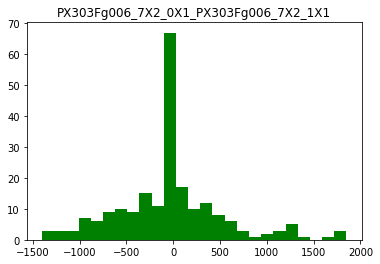

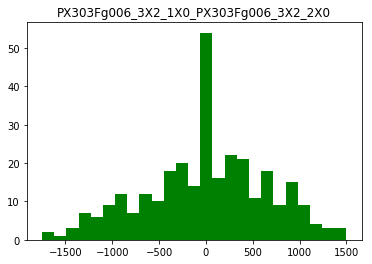

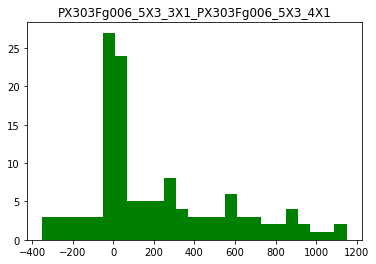

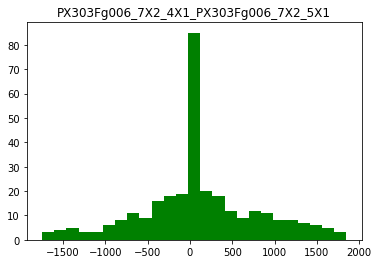

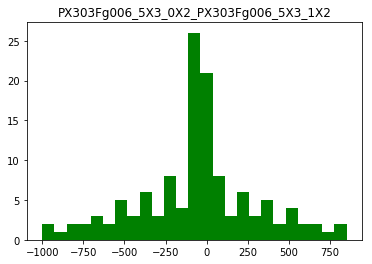

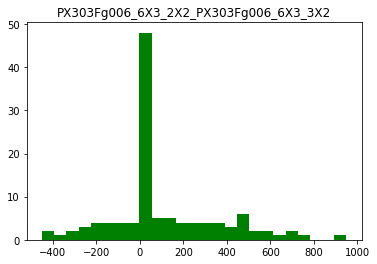

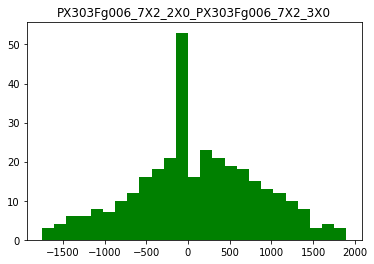

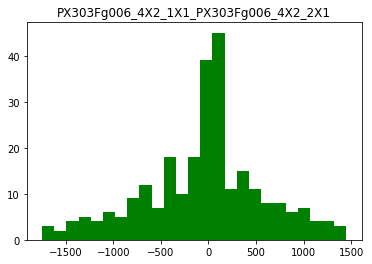

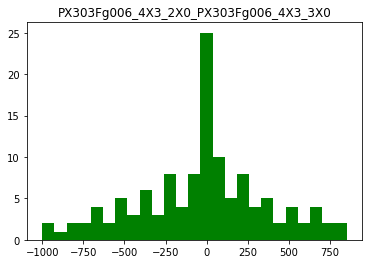

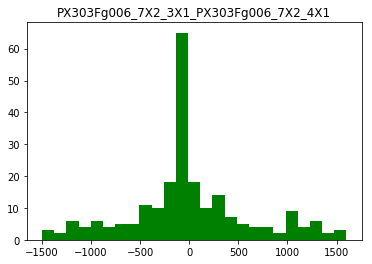

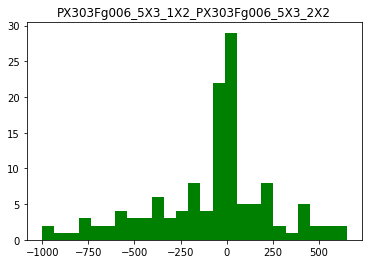

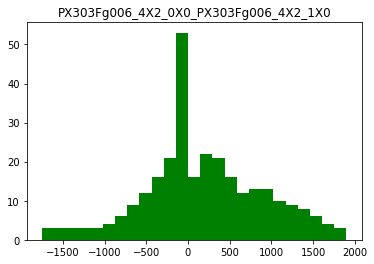

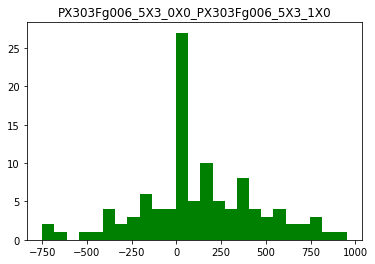

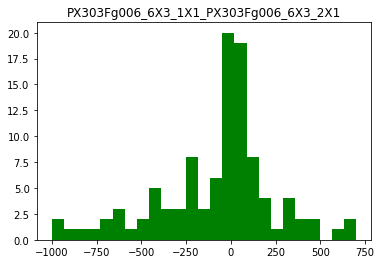

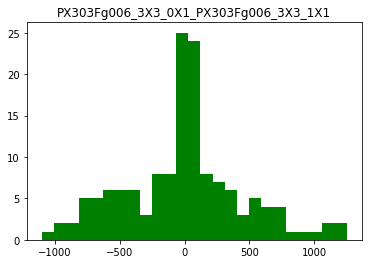

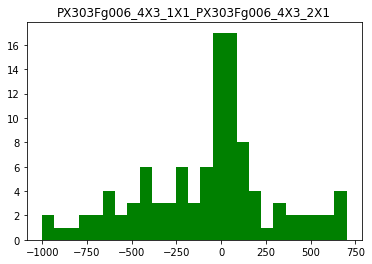

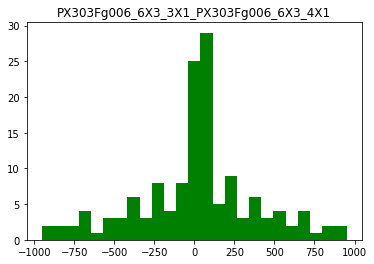

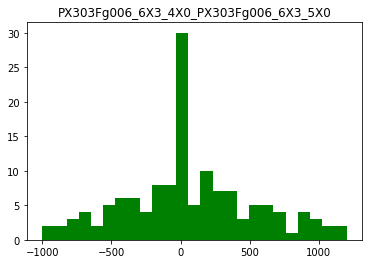

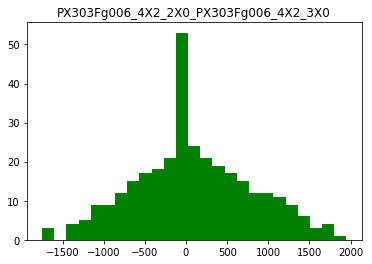

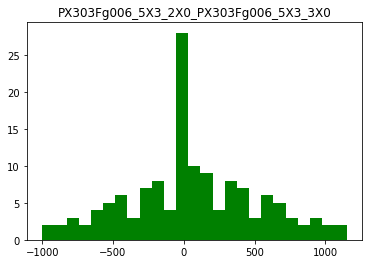

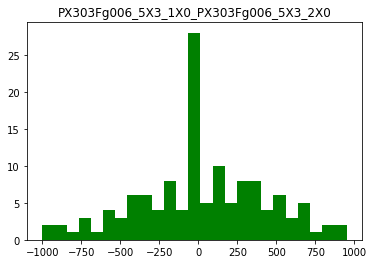

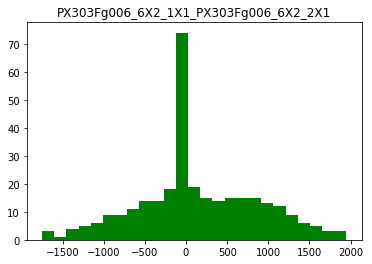

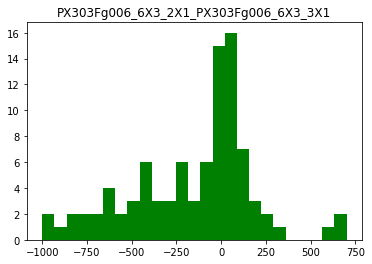

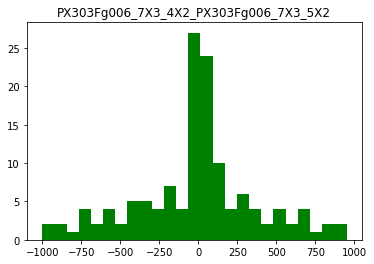

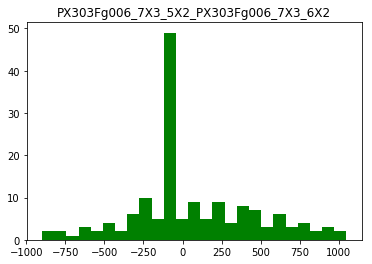

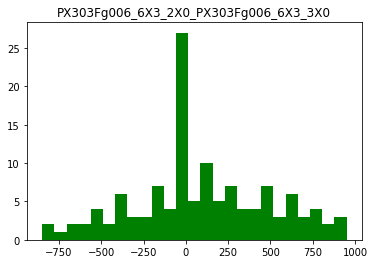

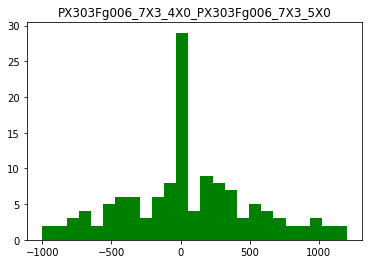

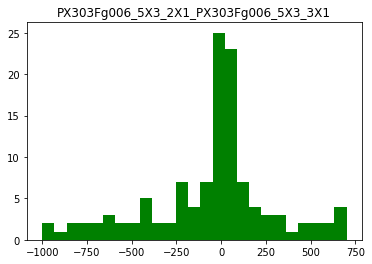

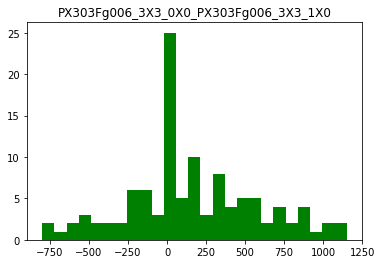

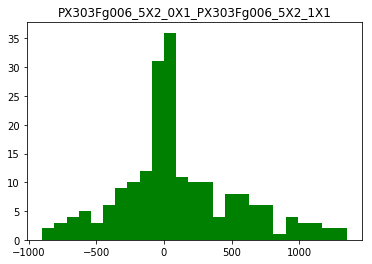

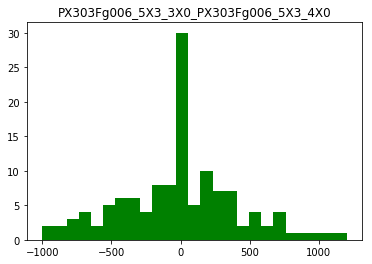

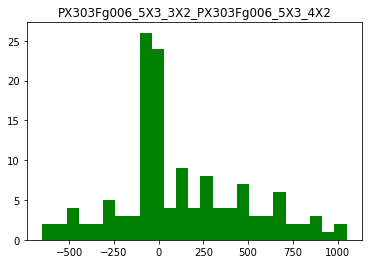

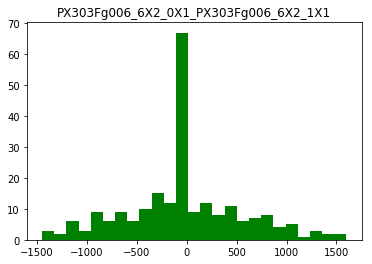

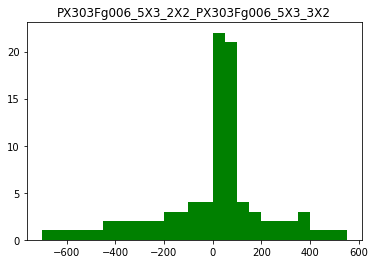

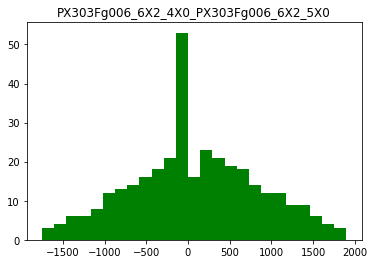

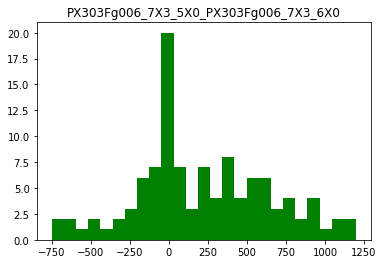

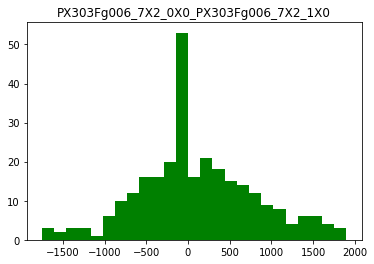

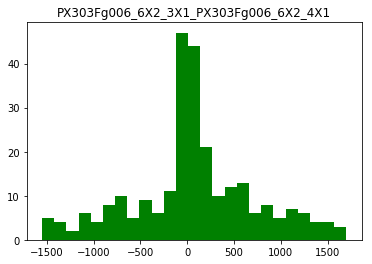

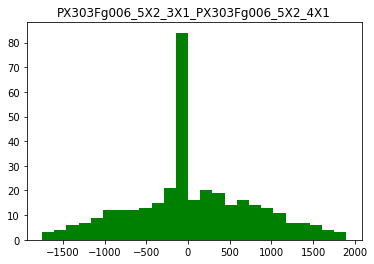

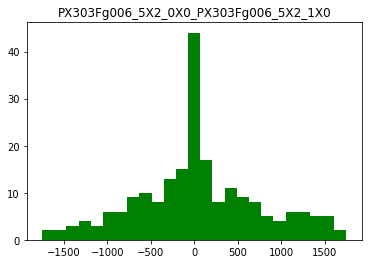

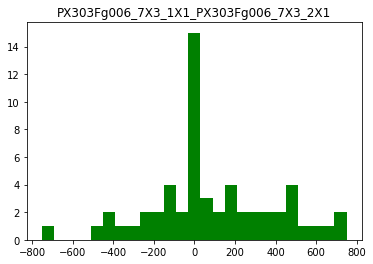

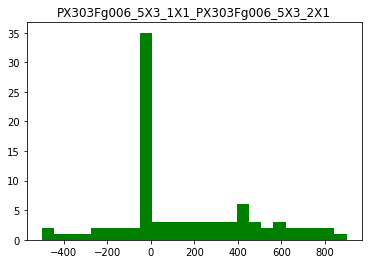

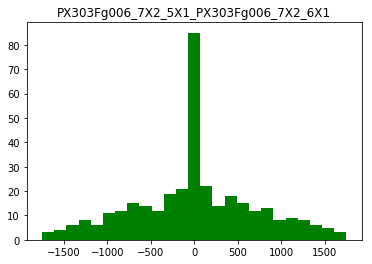

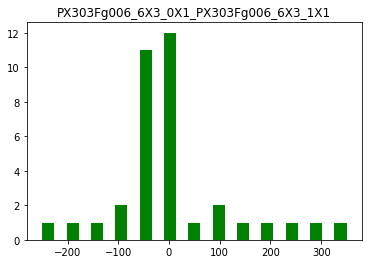

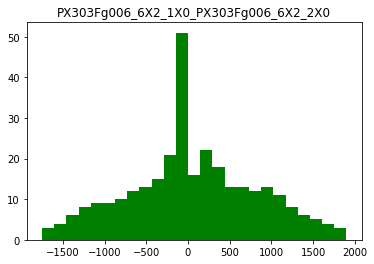

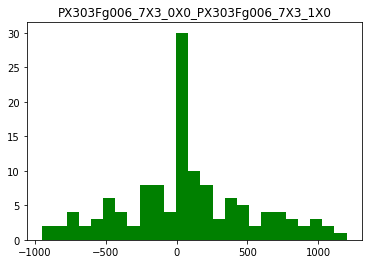

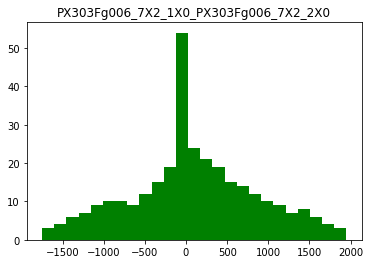

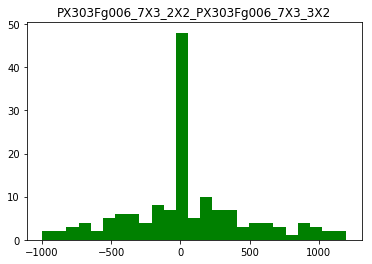

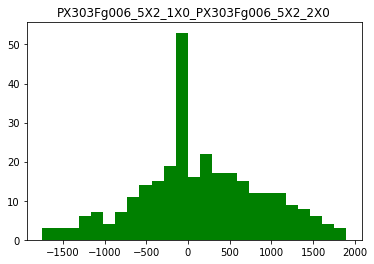

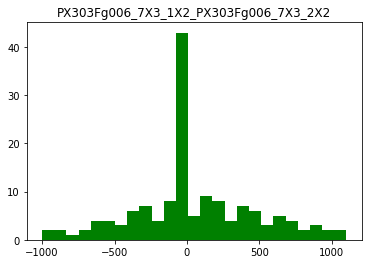

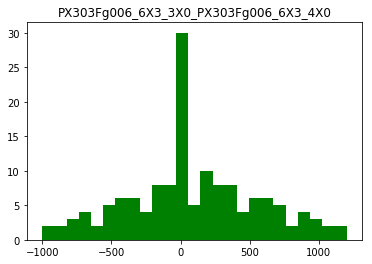

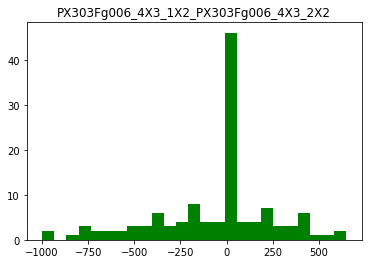

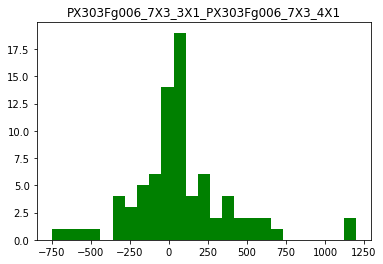

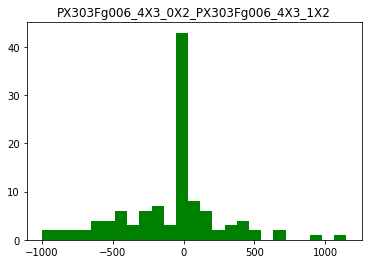

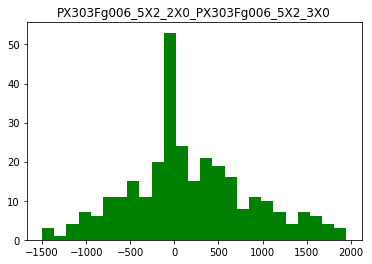

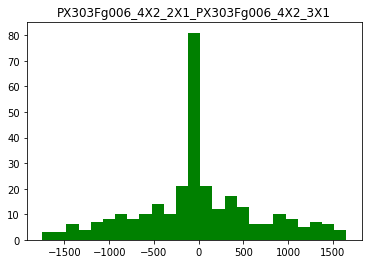

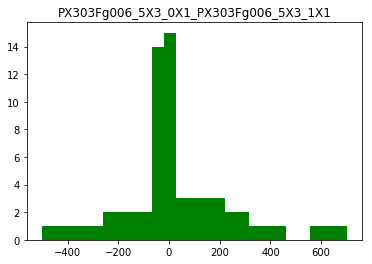

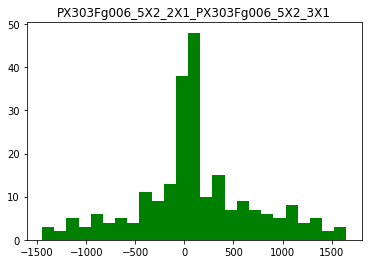

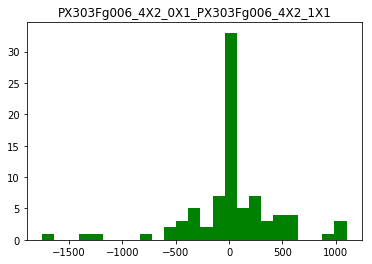

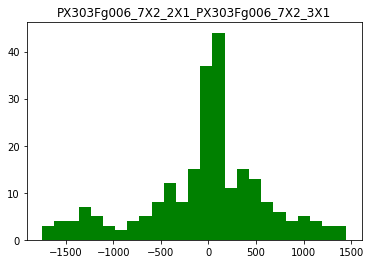

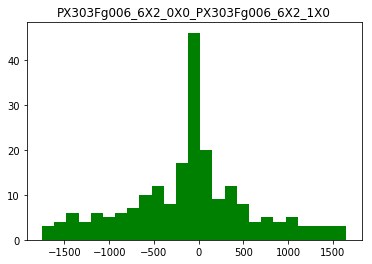

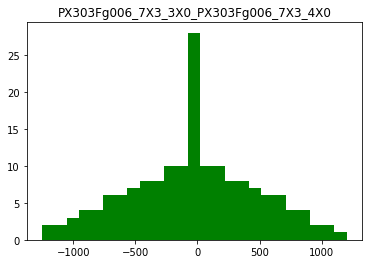

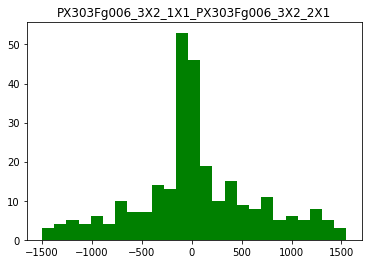

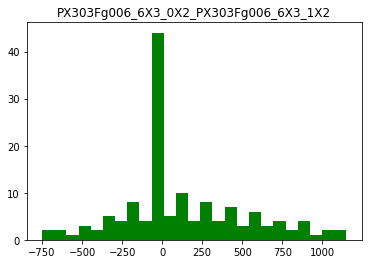

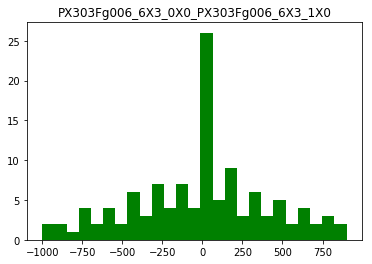

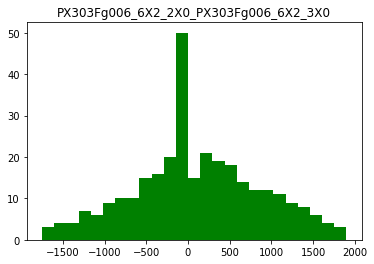

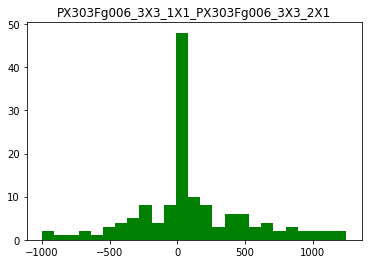

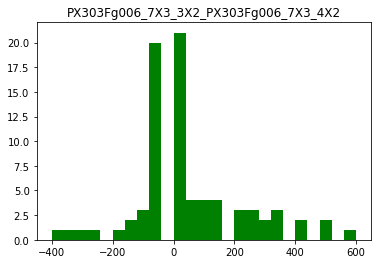

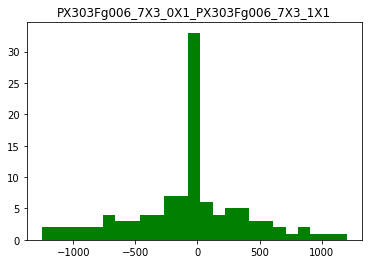

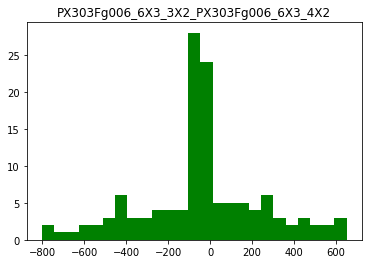

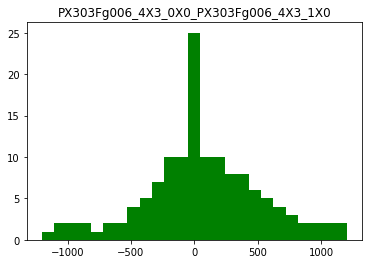

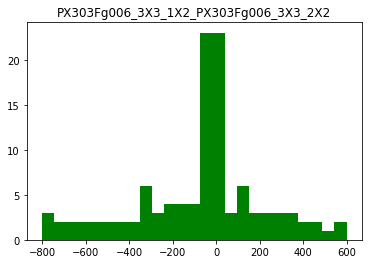

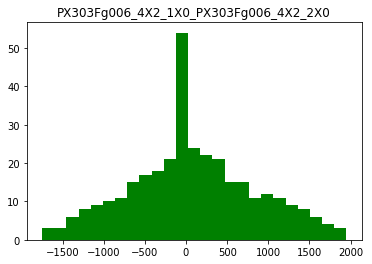

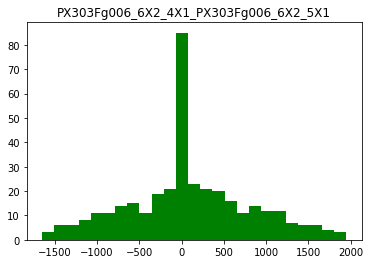

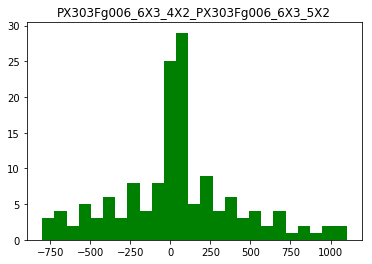

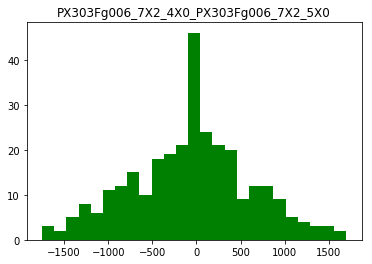

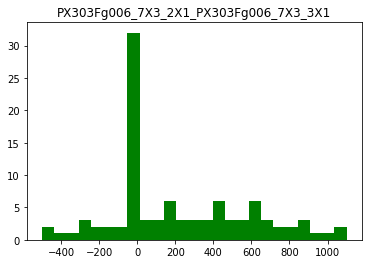

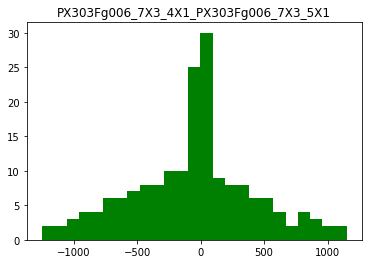

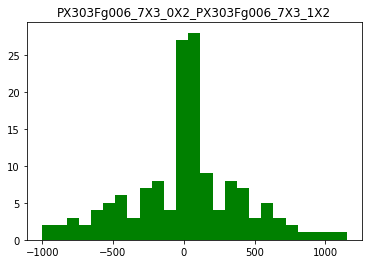

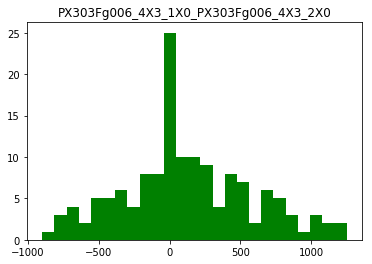

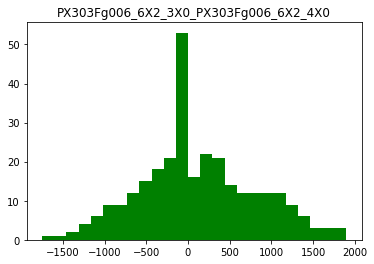

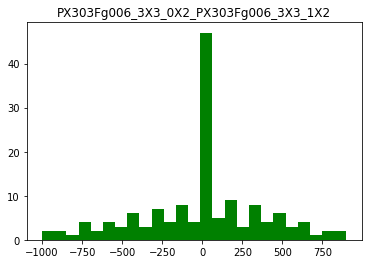

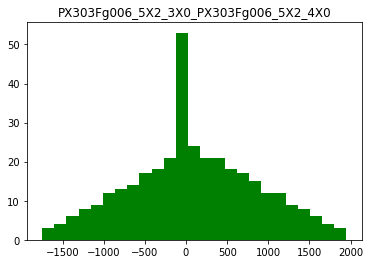

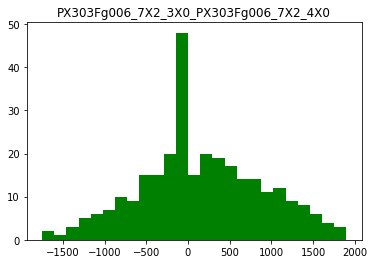

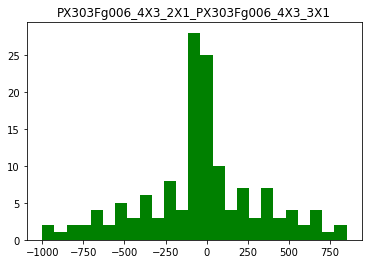

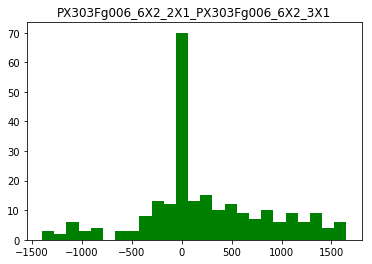

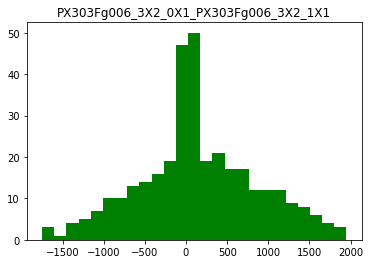

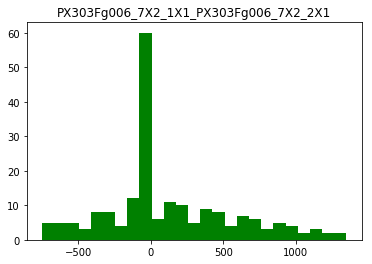

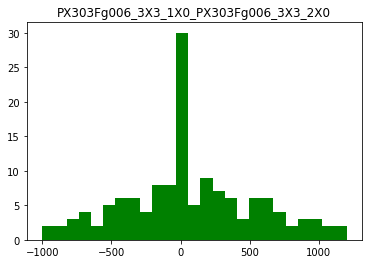

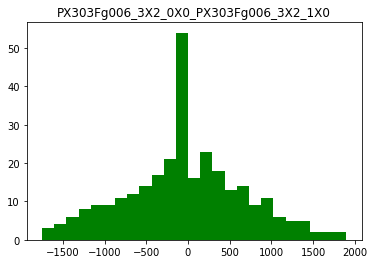

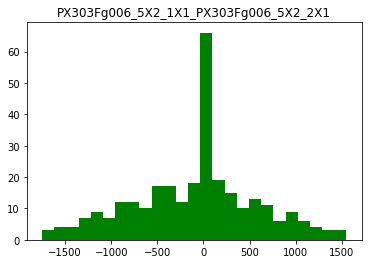

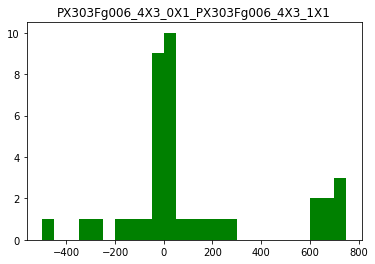

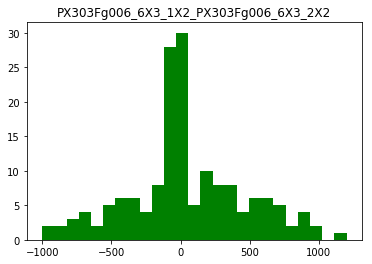

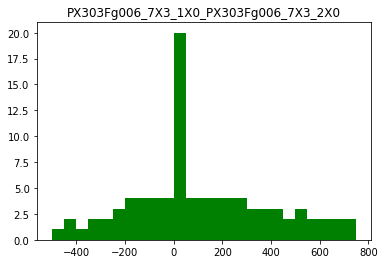

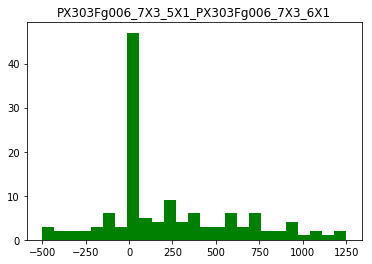

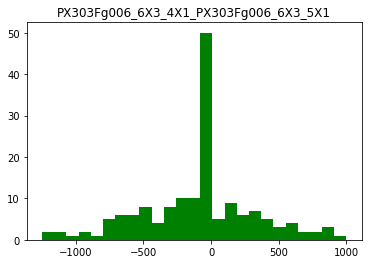

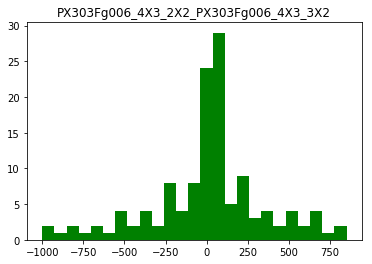

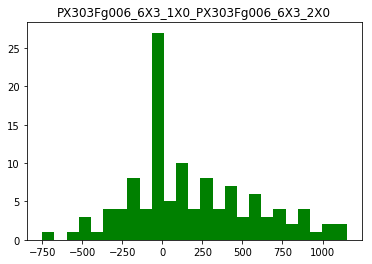

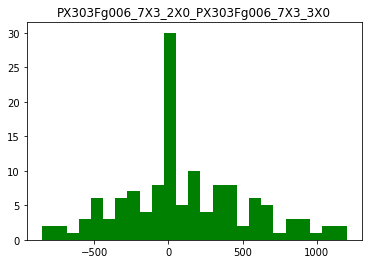

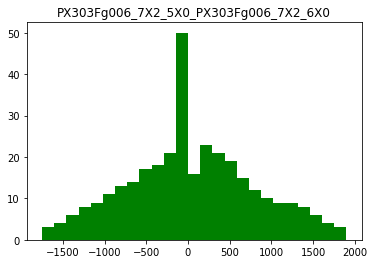

In [5]:
# OR RUN THIS: CREATE HISTOGRAM

all_matches = pd.read_csv('20190629_151937_votes_cubes_match_synt.csv') #('real_cubes_all_vote.csv')
all_matches = all_matches[all_matches["class"] == 1]
for idx, row in all_matches.iterrows():
    draw_histogram_for_row(row, 25)
